# 1. deploy_sam_on_sagemaker.ipynb
---
이 예제는 https://github.com/facebookresearch/segment-anything 를 SageMaker에서 배포하여 쉽게 segmentation을 수행할 수 있도록 합니다.
이제 **SageMaker 모델 호스팅 서비스인 SageMaker 엔드포인트**에 모델을 배포할 준비가 되었습니다. 


In [1]:
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
sagemaker.__version__

'2.210.0'

In [3]:
%load_ext autoreload
%autoreload 2

<br>

## 0. Prepare Your Model
---
SageMaker에서 사용하게 될 모델 weight를 다운로드 받습니다.

In [4]:
!sudo rm -rf ./model

In [5]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./model

--2024-03-21 04:59:56--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.66.90, 99.84.66.40, 99.84.66.18, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.66.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘./model/sam_vit_h_4b8939.pth’

100%[====================================>] 2,564,550,879  199MB/s   in 12s    

2024-03-21 05:00:08 (206 MB/s) - ‘./model/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



`Session()`은 AWS 환경에 접속하는 접속 정보와 SageMaker에서 사용하는 리소스를 관리하기 위한 편리한 방법을 제공합니다. 

In [6]:
import boto3
import sagemaker
import json

sess = sagemaker.Session()
sm_session = sagemaker.session.Session()
boto_session = boto3.session.Session()
sm_client = boto3.client("sagemaker")
bucket = sm_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto_session.region_name

print((bucket, role))

('sagemaker-us-west-2-322537213286', 'arn:aws:iam::322537213286:role/service-role/AmazonSageMaker-ExecutionRole-20230604T222555')


<br>

## 1. Create Model Serving Script

---

아래 코드 셀은 src 디렉토리에 SageMaker 추론 스크립트를 저장합니다.

#### Option 1.
- `model_fn(model_dir)`: S3의 `model_dir`에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. `content_type`은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: `application/x-npy`, `application/json`, `application/csv`등)
- `predict_fn(input_object, model)`: `input_fn(...)`을 통해 들어온 데이터에 대해 추론을 수행합니다.
- `output_fn(prediction, accept_type)`: `predict_fn(...)`에서 받은 추론 결과를 후처리를 거쳐 프론트엔드로 전송합니다.

#### Option 2.
- `model_fn(model_dir)`: S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `transform_fn(model, request_body, content_type, accept_type)`: `input_fn(...), predict_fn(...), output_fn(...)`을 `transform_fn(...)`으로 통합할 수 있습니다.

In [7]:
!cd model && sudo rm -rf /code && mkdir code

In [8]:
%%writefile model/code/requirements.txt
git+https://github.com/facebookresearch/segment-anything.git

Writing model/code/requirements.txt


In [9]:
%%writefile model/code/inference.py
import json
import base64
import numpy as np
from io import BytesIO
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry

def _encode(image):
    img = image
    img_byte_arr = BytesIO()
    img.save(img_byte_arr, format="PNG")
    img_byte_arr = img_byte_arr.getvalue()
    img_byte_arr = base64.b64encode(img_byte_arr).decode()
    return img_byte_arr


def _decode(image):
    image = base64.b64decode(image)
    image = Image.open(BytesIO(image))
    return image


def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    print("--------------- model_fn Start ---------------")
    sam = sam_model_registry["vit_h"](checkpoint=model_dir + "/sam_vit_h_4b8939.pth")
    sam.to(device='cuda')
    
    predictor = SamPredictor(sam)
    print("--------------- model_fn End ---------------")
    return predictor
                     

def input_fn(data, request_content_type):
    """
    The SageMaker XGBoost model server receives the request data body and the content type,
    and invokes the `input_fn`.
    Return a DMatrix (an object that can be passed to predict_fn).
    """
    print("Content type: ", request_content_type)
    if request_content_type == "application/json":        
        input_data = json.loads(data)
        face_image = _decode(input_data["encode_image"])
        numpy_image = np.array(face_image)
        input_box = np.array(input_data["input_box"])
        return (numpy_image, input_box)
    else:
        raise ValueError(
            "Content type {} is not supported.".format(request_content_type)
        )
        

def predict_fn(input_data, predictor):
    """
    SageMaker model server invokes `predict_fn` on the return value of `input_fn`.
    Return a two-dimensional NumPy array (predictions and scores)
    """
    
    numpy_image = input_data[0]
    input_box = input_data[1]
    input_label = np.array([0])
    
    predictor.set_image(numpy_image)
    masks, _, _ = predictor.predict(box=input_box,
                                    point_labels=input_label,
                                    multimask_output=False)
    
    return masks


def output_fn(masks, content_type="application/json"):
    """
    After invoking predict_fn, the model server invokes `output_fn`.
    """
    mask = (np.array(masks[0])) * 255.0
    mask = 255 - mask
    mask_img = Image.fromarray(mask)
    mask_img = mask_img.convert('RGB')    
    
    image_final = _encode(mask_img)

    return json.dumps({"mask_image": image_final})

Writing model/code/inference.py


<br>

## 2. Deploy a trained model from Amazon S3
---

SageMaker API의 `Model` 클래스는 훈련한 모델을 서빙하기 위한 모델 아티팩트와 도커 이미지를 정의합니다. 
`Model` 클래스 인스턴스 호출 시 AWS에서 사전 빌드한 도커 이미지 URL을 직접 가져올 수도 있지만, Model의 자식 클래스로(예: `XGBoostModel`, `TensorFlowModel`) 초기화하면 파라메터에 버전만 지정하는 것만으로 편리하게 추론을 수행하는 환경을 정의할 수 있습니다.

### Upload model/source artifacts to S3
압축한 모델 아티팩트를 Amazon S3로 복사합니다.

In [10]:
prefix = 'sam/deploy'
s3_model_path = f's3://{bucket}/{prefix}/model.tar.gz'
!cd model && tar -czvf model.tar.gz sam_vit_h_4b8939.pth ./code && mv model.tar.gz ../
!aws s3 cp model.tar.gz {s3_model_path}
!rm -rf model.tar.gz

sam_vit_h_4b8939.pth
./code/
./code/inference.py
./code/requirements.txt
upload: ./model.tar.gz to s3://sagemaker-us-west-2-322537213286/sam/deploy/model.tar.gz


<br>

## 2.1. Deploy to Local Environment: Model class

SageMaker 호스팅 엔드포인트로 배포하기 전에 로컬 모드 엔드포인트로 배포할 수 있습니다. 로컬 모드는 현재 개발 중인 환경에서 도커 컨테이너를 실행하여 SageMaker 프로세싱/훈련/추론 작업을 에뮬레이트할 수 있습니다. 추론 작업의 경우는 Amazon ECR의 딥러닝 프레임워크 기반 추론 컨테이너를 로컬로 가져오고(docker pull) 컨테이너를 실행하여(docker run) 모델 서버를 시작합니다.

아래 코드를 보시면 아시겠지만, 지속적으로 업데이트되는 파이썬 버전&프레임워크 버전&트랜스포머 버전에 쉽게 대응할 수 있습니다. AWS에서 관리하고 있는 딥러닝 컨테이너(DLC) 목록을 아래 주소에서 확인해 보세요.
- https://github.com/aws/deep-learning-containers/blob/master/available_images.md

#### Create Model

In [11]:
instance_type='local_gpu'

In [12]:
from pathlib import Path
import time

# source_dir=f"file://{Path.cwd()}/src"

if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    from sagemaker.local import entities
    # entities.HEALTH_CHECK_TIMEOUT_LIMIT=300  
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    
    model_data_url=f"file://{Path.cwd()}/model"
    model_data=f"file://{Path.cwd()}/model.tar.gz"
else:
    sagemaker_session = sagemaker.session.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data_url=s3_model_path
    
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"sam-model-{ts}"
endpoint_config_name = f"sam-endpoint-config-{ts}"
endpoint_name = f"sam-endpoint-{ts}"

In [13]:
# ecr_image_uri = '763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310-cu118-ubuntu20.04-sagemaker'
ecr_image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch', 
    version='2.1.0',
    instance_type='ml.g4dn.2xlarge',
    region='us-west-2', 
    image_scope='inference'
)

In [14]:
local_container = {
   "Image": ecr_image_uri,
   "ModelDataUrl" : model_data_url,
   "ModelDataSource": {
           "S3DataSource": {
               "S3Uri": model_data_url,
               "S3DataType": "S3Prefix",
               "CompressionType": "None",  ## local
           },
       },
   "Environment": {}
}

In [15]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=local_container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            "ContainerStartupHealthCheckTimeoutInSeconds": 3600,
        }
    ],
)

In [16]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [17]:
# !docker kill 6f6a5ef17e66

In [18]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

Attaching to w4o52k1rt8-algo-1-7pgnw
w4o52k1rt8-algo-1-7pgnw  | Collecting git+https://github.com/facebookresearch/segment-anything.git (from -r /opt/ml/model/code/requirements.txt (line 1))
w4o52k1rt8-algo-1-7pgnw  |   Cloning https://github.com/facebookresearch/segment-anything.git to /home/model-server/tmp/pip-req-build-803xaz0o
w4o52k1rt8-algo-1-7pgnw  |   Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /home/model-server/tmp/pip-req-build-803xaz0o
w4o52k1rt8-algo-1-7pgnw  |   Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
w4o52k1rt8-algo-1-7pgnw  |   Preparing metadata (setup.py) ... done
w4o52k1rt8-algo-1-7pgnw  | Building wheels for collected packages: segment-anything
w4o52k1rt8-algo-1-7pgnw  |   Building wheel for segment-anything (setup.py) ... done
w4o52k1rt8-algo-1-7pgnw  |   Created wheel for segment-anything: filename=segment_anything-1.0-py3

In [19]:
!docker ps

CONTAINER ID   IMAGE                                                                            COMMAND                  CREATED          STATUS         PORTS                                                 NAMES
a190aefada8d   763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310   "python /usr/local/b…"   10 seconds ago   Up 9 seconds   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp, 8081/tcp   w4o52k1rt8-algo-1-7pgnw


In [70]:
import base64
from PIL import Image
from io import BytesIO

def encode_image(image, formats="PNG"):
    buffer = BytesIO()
    image.save(buffer, format=formats)
    img_str = base64.b64encode(buffer.getvalue())
    return img_str


def decode_image(img):
    img = img.encode("utf8") if type(img) == "bytes" else img
    buff = BytesIO(base64.b64decode(img))
    image = Image.open(buff)
    return image

In [21]:
img_path = f'../test_images/andy_portrait_2.jpg' ## 원하는 이미지를 선택합니다.

In [27]:
import boto3
import copy
from botocore.config import Config


def label_list():
    import pandas as pd
    pd.set_option('display.max_columns', 150)
    pd.set_option('display.max_colwidth', None)
    
    ## 모델 별 label list : https://docs.aws.amazon.com/rekognition/latest/dg/labels.html
    label_path = '../AmazonRekognitionBoundingBoxLabels_v3.0.csv'

    csv_file = pd.read_csv(label_path)
    label_lists = list(csv_file['Label'].values)
    
    label_table = {}
    label_cnt = {}
    max_cnt = 0
    for label_item in label_lists:
        start_char = label_item[0]
        # print(start_char)
        if label_table.get(start_char):
            label_table[start_char].append(label_item)
            label_cnt[start_char] += 1
            if max_cnt < label_cnt[start_char]:
                max_cnt = label_cnt[start_char]
        else:
            label_table[start_char] = [label_item]
            label_cnt[start_char] = 1

    for start_char in label_cnt:
        iter_cnt = max_cnt - label_cnt[start_char]
        for _ in range(iter_cnt):
            label_table[start_char].append('-')

    return pd.DataFrame(label_table)


def boto3_runtime(service_name, target_region):
    session_kwargs = {"region_name": target_region}
    client_kwargs = {**session_kwargs}

    retry_config = Config(
        region_name=target_region,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )

    session = boto3.Session(**session_kwargs)

    boto3_runtime = session.client(
        service_name=service_name,
        config=retry_config,
        **client_kwargs
    )
    
    return boto3_runtime


def show_faces(img_path, target_region='us-west-2'):
    client = boto3_runtime(
        service_name='rekognition',
        target_region=target_region
    )
    
    with open(img_path, 'rb') as image:
        #Call DetectFaces 
        response = client.detect_faces(Image={'Bytes': image.read()},Attributes=['ALL'])

        image = Image.open(img_path).convert('RGB')
        imgWidth, imgHeight = image.size       
        ori_image = copy.deepcopy(image)

        for faceDetail in response['FaceDetails']:
            print('The detected face is between ' + str(faceDetail['AgeRange']['Low']) 
                  + ' and ' + str(faceDetail['AgeRange']['High']) + ' years old')

            box = faceDetail['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']


            print('Left: ' + '{0:.0f}'.format(left))
            print('Top: ' + '{0:.0f}'.format(top))
            print('Face Width: ' + "{0:.0f}".format(width))
            print('Face Height: ' + "{0:.0f}".format(height))

    return ori_image, imgWidth, imgHeight, int(left), int(top), int(width), int(height), response


def show_labels(img_path, target_label=None, target_region='us-west-2'):
    client = boto3_runtime(
        service_name='rekognition',
        target_region=target_region
    )
    
    if target_label is None:
        Settings = {"GeneralLabels": {"LabelInclusionFilters":[]},"ImageProperties": {"MaxDominantColors":1}}
        # print(f"target_label_None : {target_label}")
    else:
        Settings = {"GeneralLabels": {"LabelInclusionFilters":[target_label]},"ImageProperties": {"MaxDominantColors":1}}
        # print(f"target_label : {target_label}")
    
    box = None
    with open(img_path, 'rb') as image:
        #Call DetectFaces 
        response = client.detect_labels(Image={'Bytes': image.read()},
                                        MaxLabels=15,
                                        MinConfidence=0.7,
                                        # Uncomment to use image properties and filtration settings
                                        Features=["GENERAL_LABELS", "IMAGE_PROPERTIES"],
                                        Settings=Settings
                                       )

        image = Image.open(img_path).convert('RGB')
        imgWidth, imgHeight = image.size       
        ori_image = copy.deepcopy(image)
        color = 'white'
    
        for item in response['Labels']:
            # print(item)
            if len(item['Instances']) > 0:
                print(item)
                print(item['Name'], item['Confidence'])

                for sub_item in item['Instances']:
                    color = sub_item['DominantColors'][0]['CSSColor']
                    box = sub_item['BoundingBox']
                    break
            break
        try:
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']


            print('Left: ' + '{0:.0f}'.format(left))
            print('Top: ' + '{0:.0f}'.format(top))
            print('Object Width: ' + "{0:.0f}".format(width))
            print('Object Height: ' + "{0:.0f}".format(height))
            return ori_image, imgWidth, imgHeight, int(left), int(top), int(width), int(height), color, response
        except:
            print("There is no target label in the image.")
            return _, _, _, _, _, _, _, _, _

    

In [28]:
label_list()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,Z
0,Adult,Baby,Camera,Dagger,E-scooter,Face,Gas Pump,Hammer,Ice Cream,Jacket,Kangaroo,Lamp,Mace Club,Necklace,Orange,Package,QR Code,Rat,Sandal,T-Shirt,Utility Pole,Vest,Wallet,Zebra
1,Airplane,Backpack,Can,Desk,Earbuds,Female,Gate,Handbag,Ice Hockey Puck,Jeans,Kayak,Laptop,Mailbox,Notebook,Overcoat,Painting,-,Razor,Sandwich,Tablet Computer,-,Violin,Washer,-
2,Altar,Balloon,Candle,Diamond,Earring,Field Hockey Stick,Giant Panda,Handcuffs,Ice Hockey Stick,-,Ketchup,Lawn Mower,Male,-,-,Pajamas,-,Refrigerator,Scarf,Tank,-,Volleyball (Ball),Wedding Cake,-
3,American Football (Ball),Banana,Canoe,Diaper,Egg,Fire Hydrant,Giraffe,Hanukkah Menorah,Id Cards,-,Kitchen Island,License Plate,Man,-,-,Panther,-,Remote Control,Scissors,Tape,-,VR Headset,Wedding Gown,-
4,Antelope,Baseball (Ball),Car,Dining Table,Elephant,Fire Truck,Girl,Hardhat,Insect,-,Knife,Lifejacket,Microphone,-,-,Pants,-,Ring,Scoreboard,Tattoo,-,-,Wheel,-
5,Apple,Baseball Bat,Cat,Dinosaur,-,Fireplace,Glasses,Hat,-,-,-,Lighthouse,Microwave,-,-,Passport,-,Road Sign,Screw,Teddy Bear,-,-,White Board,-
6,Arrow,Baseball Cap,Ceiling Fan,Disk,-,First Aid,Glove,Head,-,-,-,Limo,Milk,-,-,Pear,-,Rocket,Screwdriver,Teen,-,-,Windmill,-
7,Axe,Baseball Glove,Chair,Disposable Cup,-,Fish,Grenade,Headphones,-,-,-,Lion,Mixer,-,-,Pen,-,Rose,Shaker,Tennis Ball,-,-,Woman,-
8,-,Basketball (Ball),Chandelier,Document,-,Flag,Guitar,Helicopter,-,-,-,Lipstick,Mobile Phone,-,-,Penguin,-,Rug,Shark,Tennis Racket,-,-,Wristwatch,-
9,-,Bathtub,Cheetah,Dog,-,Flyer,Gun,Helmet,-,-,-,Lizard,Monitor,-,-,Perfume,-,Rugby Ball,Sheep,Tent,-,-,-,-


In [31]:
object_image, width, height, f_left, f_top, f_width, f_height, color, human_res = show_labels(img_path) ## detect_faces
# object_image, width, height, f_left, f_top, f_width, f_height, color, human_res = show_labels(img_path, target_label="Car")

{'Name': 'Person', 'Confidence': 99.99996185302734, 'Instances': [{'BoundingBox': {'Width': 0.6450134515762329, 'Height': 0.9341679215431213, 'Left': 0.1814950555562973, 'Top': 0.06236381456255913}, 'Confidence': 99.60304260253906, 'DominantColors': [{'Red': 47, 'Blue': 79, 'Green': 79, 'HexCode': '#2f4f4f', 'CSSColor': 'darkslategrey', 'SimplifiedColor': 'grey', 'PixelPercent': 39.2299690246582}]}], 'Parents': [], 'Aliases': [{'Name': 'Human'}], 'Categories': [{'Name': 'Person Description'}]}
Person 99.99996185302734
Left: 258
Top: 50
Object Width: 917
Object Height: 747


In [32]:
import numpy as np

encode_object_image = encode_image(object_image,formats="PNG").decode("utf-8")

inputs = dict(
    encode_image = encode_object_image,
    input_box = [f_left, f_top, f_left+f_width, f_top+f_height]
)

w4o52k1rt8-algo-1-7pgnw  | 2024-03-21T05:06:06,155 [INFO ] epollEventLoopGroup-3-2 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:a190aefada8d,timestamp:1710997566
w4o52k1rt8-algo-1-7pgnw  | 2024-03-21T05:06:06,156 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1710997566156
w4o52k1rt8-algo-1-7pgnw  | 2024-03-21T05:06:06,158 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - --------------- model_fn Start ---------------
w4o52k1rt8-algo-1-7pgnw  | 2024-03-21T05:06:06,159 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - --------------- model_fn End ---------------
w4o52k1rt8-algo-1-7pgnw  | 2024-03-21T05:06:06,159 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1710997566
w4o52k1rt8-algo-1-7pgnw  | 2024-03-21T05:06:06,977 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Content type:  application/json
w4o52k1rt8-algo-1-7pgnw  | 2024-03-21T05:06:06,978 [INFO ] W-9000-mod

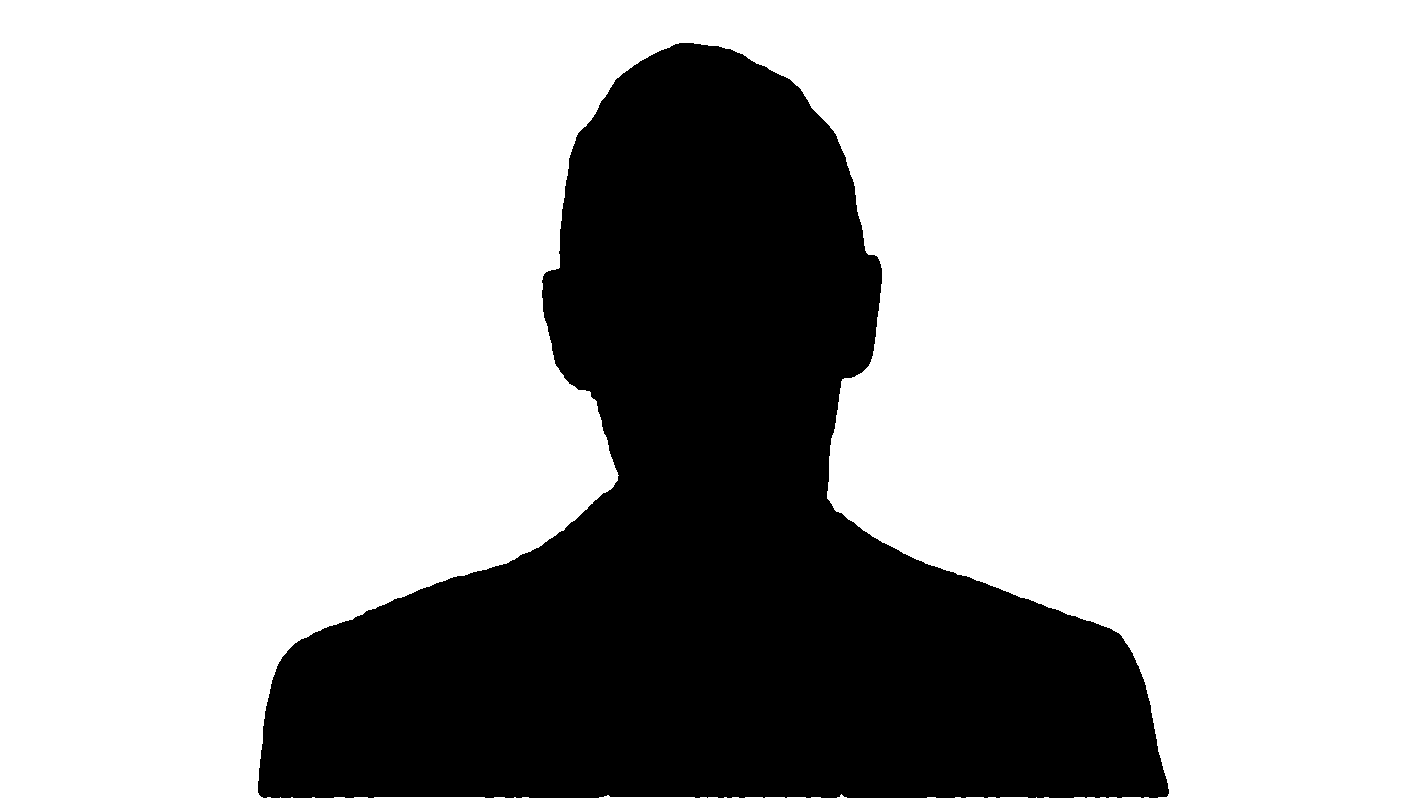

In [33]:
def invoke_endpoint(endpoint_name, payload):

    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Accept="application/json",
        ContentType="application/json",
        Body=json.dumps(payload)
    )
    data = response["Body"].read().decode("utf-8")
    return data

predictions = invoke_endpoint(endpoint_name, inputs)

mask_image = decode_image(json.loads(predictions)['mask_image'])
mask_image

#### Check Docker

모델 서빙을 위한 도커 컨테이너가 구동되고 있음을 확인할 수 있습니다.

In [34]:
!docker ps

CONTAINER ID   IMAGE                                                                            COMMAND                  CREATED         STATUS         PORTS                                                 NAMES
a190aefada8d   763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310   "python /usr/local/b…"   3 minutes ago   Up 3 minutes   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp, 8081/tcp   w4o52k1rt8-algo-1-7pgnw


In [35]:
# !docker kill a110dfb8db5e

#### Local Mode Endpoint Clean-up

In [36]:
try:
    sm_client.delete_endpoint(EndpointName=endpoint_name)
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    sm_client.delete_model(ModelName=sm_model_name)
except:
    print("If any docker processes are running,Retry this cell, please.")
finally:
    !docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


<br>

## 2.2. Deploy to Hosting Instance

로컬 모드에서 충분히 디버깅했으면 실제 호스팅 인스턴스로 배포할 차례입니다. 코드는 거의 동일하며, `instance_type`만 다르다는 점을 주목해 주세요! 

#### Create Model

In [37]:
instance_type='ml.g4dn.xlarge'

In [38]:
from pathlib import Path
import time

# source_dir=f"file://{Path.cwd()}/src"

if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    from sagemaker.local import entities
    # entities.HEALTH_CHECK_TIMEOUT_LIMIT=300  
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    
    model_data_url=f"file://{Path.cwd()}/model"
    model_data=f"file://{Path.cwd()}/model.tar.gz"
else:
    sagemaker_session = sagemaker.session.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data_url=s3_model_path
    
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"sam-model-{ts}"
endpoint_config_name = f"sam-endpoint-config-{ts}"
endpoint_name = f"sam-endpoint-{ts}"

In [39]:
container = {
    "Image": ecr_image_uri,
    "ModelDataSource": {
            "S3DataSource": {
                "S3Uri": model_data_url,
                "S3DataType": "S3Object",
                "CompressionType": "Gzip", ## SageMaker Hosting
            },
        },
    "Environment": {}
}

In [40]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            # "ContainerStartupHealthCheckTimeoutInSeconds": 600
        }
    ]
)

#### Create Endpoint

In [41]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, 
    EndpointConfigName=endpoint_config_name
)

### Wait for the endpoint jobs to complete

엔드포인트가 생성될 때까지 기다립니다. 엔드포인트가 가리키는 호스팅 리소스를 프로비저닝하는 데에 몇 분의 시간이 소요됩니다. 

In [42]:
sess.wait_for_endpoint(endpoint_name, poll=5)

------------------------------------------------------------!

{'EndpointName': 'sam-endpoint-2024-03-21-05-06-39',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:322537213286:endpoint/sam-endpoint-2024-03-21-05-06-39',
 'EndpointConfigName': 'sam-endpoint-config-2024-03-21-05-06-39',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310',
     'ResolvedImage': '763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference@sha256:d6344a1c254a71cae1f39de2d2ec72022e42209ee487ee83dca4a2bdd11bee02',
     'ResolutionTime': datetime.datetime(2024, 3, 21, 5, 6, 44, 421000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 3, 21, 5, 6, 43, 784000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 3, 21, 5, 11, 49, 575000, tzinfo=tzlocal()),
 'ResponseMetadata': {'Request

In [47]:
%store endpoint_name img_path ecr_image_uri model_data_url

Stored 'endpoint_name' (str)
Stored 'img_path' (str)
Stored 'ecr_image_uri' (str)
Stored 'model_data_url' (str)


In [48]:
def invoke_endpoint(endpoint_name, payload):
    smr_client = boto3.client("sagemaker-runtime")
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Accept="application/json",
        ContentType="application/json",
        Body=json.dumps(payload)
    )
    data = response["Body"].read().decode("utf-8")
    return data

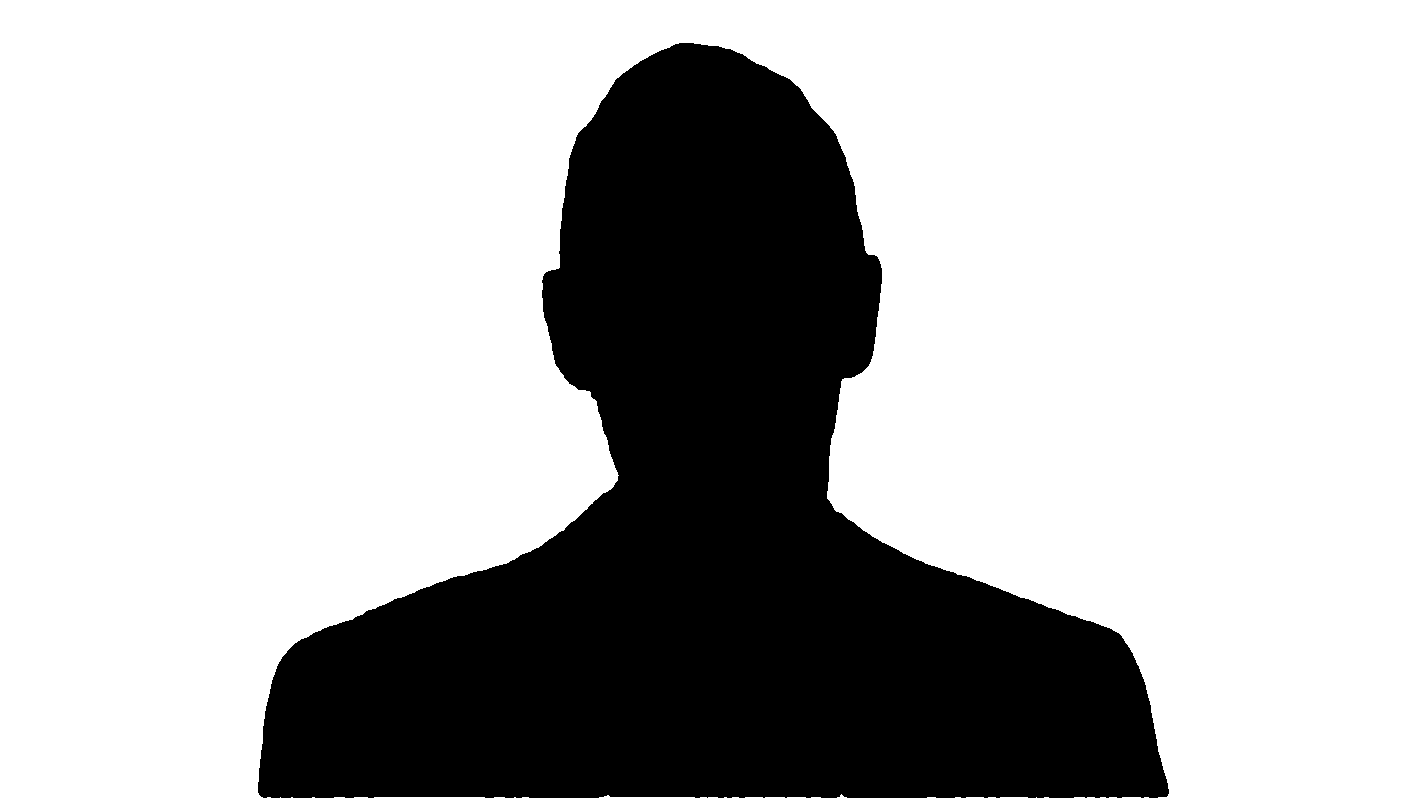

In [49]:
predictions = invoke_endpoint(endpoint_name, inputs)

mask_image = decode_image(json.loads(predictions)['mask_image'])
mask_image

In [50]:
mask_image.save('../result/generated_andy_portrait_2_mask.jpg')

## 3. Amazon Bedrock Titan Image Generation

In [51]:
import io
import os
import numpy as np
import matplotlib.pyplot as plt

def boto3_runtime(service_name, target_region=boto3.Session().region_name):
    session_kwargs = {"region_name": target_region}
    client_kwargs = {**session_kwargs}

    retry_config = Config(
        region_name=target_region,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )

    session = boto3.Session(**session_kwargs)

    boto3_runtime = session.client(
        service_name=service_name,
        config=retry_config,
        **client_kwargs
    )
    
    return boto3_runtime


def img_resize(image):
    imgWidth, imgHeight = image.size 


    if imgWidth < imgHeight:
        imgWidth = int(1024/imgHeight*imgWidth)
        imgWidth = imgWidth-imgWidth%64
        imgHeight = 1024
    else:
        imgHeight = int(1024/imgWidth*imgHeight)
        imgHeight = imgHeight-imgHeight%64
        imgWidth = 1024 

    image = image.resize((imgWidth, imgHeight), resample=0)
    return image


def image_to_base64(img) -> str:
    """Converts a PIL Image or local image file path to a base64 string"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

In [52]:
modelId = "amazon.titan-image-generator-v1"
result_path = "./result"
seed = 43
cfgScale = 7.5
# height = 1152
# width = 768
resize_yn = False

In [59]:
img_path = f'../test_images/andy_portrait_2.jpg' ## 원하는 이미지를 선택합니다.
outpaint_prompt = 'forrest'
# target_label = "Car"

In [71]:
ext = img_path.split('.')[-1]
if ext == 'jpg':
    ext = 'jpeg'

In [72]:
object_image, width, height, f_left, f_top, f_width, f_height, color, human_res = show_labels(img_path)
# object_image, width, height, f_left, f_top, f_width, f_height, color, human_res = show_labels(img_path, target_label)

{'Name': 'Person', 'Confidence': 99.99996185302734, 'Instances': [{'BoundingBox': {'Width': 0.6450134515762329, 'Height': 0.9341679215431213, 'Left': 0.1814950555562973, 'Top': 0.06236381456255913}, 'Confidence': 99.60304260253906, 'DominantColors': [{'Red': 47, 'Blue': 79, 'Green': 79, 'HexCode': '#2f4f4f', 'CSSColor': 'darkslategrey', 'SimplifiedColor': 'grey', 'PixelPercent': 39.2299690246582}]}], 'Parents': [], 'Aliases': [{'Name': 'Human'}], 'Categories': [{'Name': 'Person Description'}]}
Person 99.99996185302734
Left: 258
Top: 50
Object Width: 917
Object Height: 747


In [73]:
encode_object_image = encode_image(object_image,formats=ext.upper()).decode("utf-8")
inputs = dict(
    encode_image = encode_object_image,
    input_box = [f_left, f_top, f_left+f_width, f_top+f_height]
)

predictions = invoke_endpoint(endpoint_name, inputs)
mask_image = decode_image(json.loads(predictions)['mask_image'])

In [77]:
object_img = img_resize(object_image)
mask_img = img_resize(mask_image)

print(f"outpaint_prompt : {outpaint_prompt}, seed : {seed}")
# Payload creation
body = json.dumps({
    "taskType": "OUTPAINTING",
    "outPaintingParams": {
        "text": f'a car with a {outpaint_prompt} and {color} background',              # Optional
        # "negativeText": negative_prompts,    # Optional
        "image": image_to_base64(object_img),      # Required
        # "maskPrompt": mask_prompt,               # One of "maskImage" or "maskPrompt" is required
        "maskImage": image_to_base64(mask_img),  # Input maskImage based on the values 0 (black) or 255 (white) only
    },                                                 
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "premium",
        # "quality": "standard",
        "cfgScale": cfgScale,
        # "height": height,
        # "width": width,
        "seed": seed
    }
})

# Model invocation
boto3_bedrock = boto3_runtime(
    service_name='bedrock-runtime',
    # target_region=target_region
)

response = boto3_bedrock.invoke_model(
    body=body,
    modelId=modelId,
    accept="application/json", 
    contentType="application/json"
)

# Output processing
response_body = json.loads(response.get("body").read())
img_b64 = response_body["images"][0]
print(f"Output: {img_b64[0:80]}...")

# Decode + save
img_result = Image.open(
    io.BytesIO(
        base64.decodebytes(
            bytes(img_b64, "utf-8")
        )
    )
)
if resize_yn:
    img_result = img_result.resize((360, 480), 0)
output_path = result_path + '/generated_'+img_path.split('/')[-1]
os.makedirs(result_path, exist_ok=True)
img_result.save(output_path)
print(f"Gnerating an image in {output_path}")

outpaint_prompt : forrest, seed : 43
Output: iVBORw0KGgoAAAANSUhEUgAABAAAAAJACAIAAACc94OCAAEAAElEQVR4nCT8169uaZ4Y5v3etN6Vv/zt...
Gnerating an image in ./result/generated_andy_portrait_2.jpg


Text(0.5, 0.98, 'Image comparison')

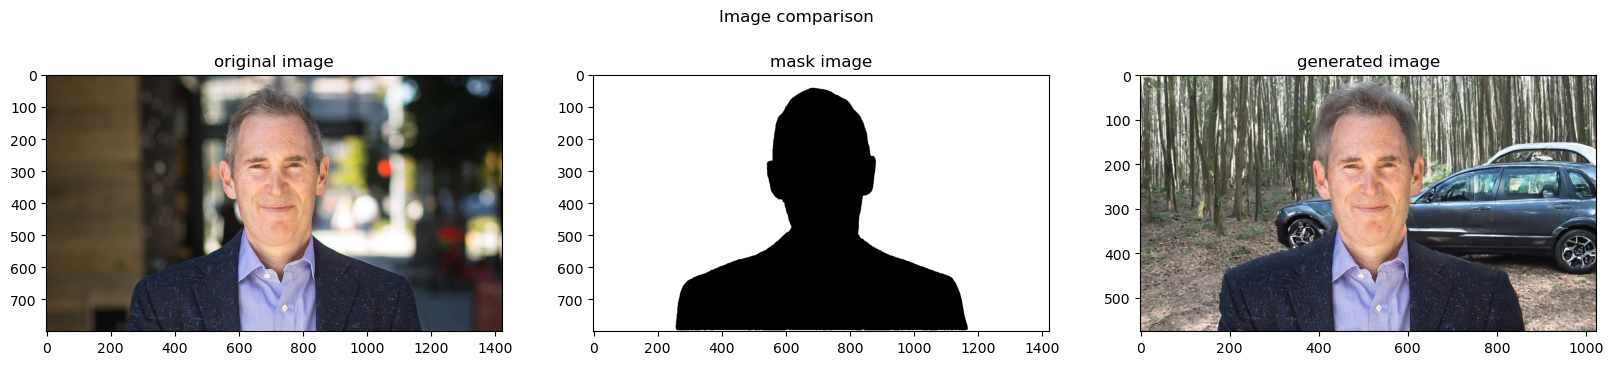

In [78]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.imshow(object_image)
plt.title('original image')

plt.subplot(1, 3, 2)
plt.imshow(mask_image)
plt.title('mask image')

plt.subplot(1, 3, 3)
plt.imshow(img_result)
plt.title('generated image')

plt.suptitle('Image comparison')

In [81]:
prompt = f"이미지에 대해 한국어로 설명을 해줘"
prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 4096,
    "temperature" : 0,
    "top_k": 350,
    "top_p": 0.999,
    "messages": [
        {
            "role": "user", "content": [
                {"type": "image", "source": {"type": "base64", "media_type": f"image/{ext}", "data": image_to_base64(object_image)}},
                {"type": "text", "text": prompt},
            ],
        }
    ],
}


body_text = json.dumps(prompt_config)

modelId_text = 'anthropic.claude-3-sonnet-20240229-v1:0'
response_text = boto3_bedrock.invoke_model(
    body=body_text,
    modelId=modelId_text,
    accept="application/json", 
    contentType="application/json"
)

import json
response_text_body = json.loads(response_text.get("body").read())
results = response_text_body.get("content")[0].get("text")

results

'이 이미지는 중년의 남성을 보여주고 있습니다. 그는 회색 머리카락과 주름진 얼굴을 가지고 있지만 미소를 짓고 있어 친근한 인상을 줍니다. 그는 점점이 있는 짙은 블루 색상의 정장 재킷과 하늘색 셔츠를 입고 있습니다. 배경은 도시의 거리 풍경으로 보이며 차량과 조명이 흐릿하게 보입니다. 전체적으로 이 사진은 도심 지역에서 찍은 캐주얼한 사진 같습니다.'

## Delete resource

In [115]:
# try:
#     sm_client.delete_endpoint(EndpointName=endpoint_name)
#     sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
#     sm_client.delete_model(ModelName=sm_model_name)
# except:
#     print("If any docker processes are running,Retry this cell, please.")

If any docker processes are running,Retry this cell, please.
